In [146]:
# 1. determine core, border and noise points [X]
# 2. connect core points within distance e
# 3. find all connected components
# 4. assign border points to closest connected component
# 5. return all components as clusters

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [148]:
def generate_moons(n = 100, noise_level=0.02):
    
    first_moon_xs = np.linspace(0, 0.4, n).reshape(-1, 1)
    second_moon_xs = np.linspace(0.25, 0.75, n).reshape(-1, 1)
    
    first_moon_noise = noise_level * np.random.random(n).reshape(-1, 1)
    second_moon_noise = noise_level * np.random.random(n).reshape(-1, 1)

    
    first_moon_ys = -np.power(first_moon_xs-0.2, 2) + first_moon_noise
    second_moon_ys = np.power(second_moon_xs-0.5, 2) + second_moon_noise
    
    first_moon = np.hstack([first_moon_xs, first_moon_ys])
    second_moon = np.hstack([second_moon_xs, second_moon_ys])
    
    return np.vstack([first_moon, second_moon])

In [149]:
def generate_rings(n = 100, noise_level = 0.1):
    
    inner_radius = 0.25
    outer_radius = 0.5
    
    on_circle = np.linspace(0, 2 * np.pi, n).reshape(-1, 1)
    
    noise = noise_level * np.random.random(n).reshape(-1, 1)
    
    inner_ring_xs = inner_radius * np.cos(on_circle) + noise
    inner_ring_ys = inner_radius * np.sin(on_circle) + noise
    
    outer_ring_xs = outer_radius * np.cos(on_circle) + noise
    outer_ring_ys = outer_radius * np.sin(on_circle) + noise
    
    inner_ring = np.hstack([inner_ring_xs, inner_ring_ys])
    outer_ring = np.hstack([outer_ring_xs, outer_ring_ys])
    
    return np.vstack([inner_ring, outer_ring])

In [150]:
def show_task(points, title):
    plt.title(title)
    plt.scatter(points[:, 0], points[:, 1])
    plt.show()

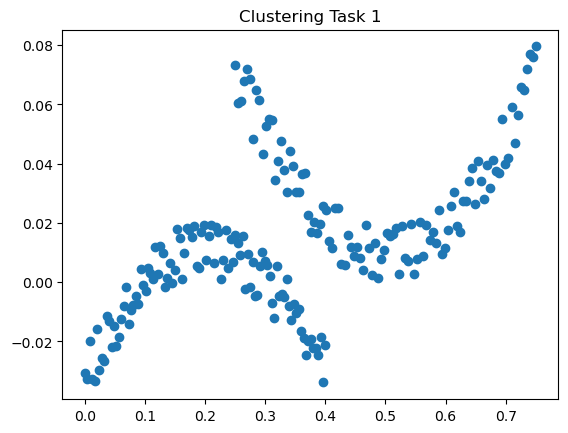

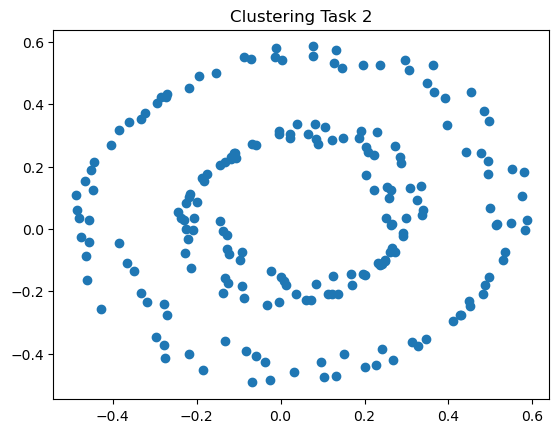

In [151]:
moons = generate_moons()
rings = generate_rings()

show_task(moons, "Clustering Task 1")
show_task(rings, "Clustering Task 2")

In [152]:
from sklearn.cluster import KMeans

random_state = 42


def show_k_means_clustering(points, title):
    
    kmeans = KMeans(n_clusters = 2, random_state = random_state).fit(points)
    plt.title(title)
    plt.scatter(points[:, 0], points[:, 1], c = kmeans.labels_)
    
    # zeichne centroids separat
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], c="red")
    
    plt.show()

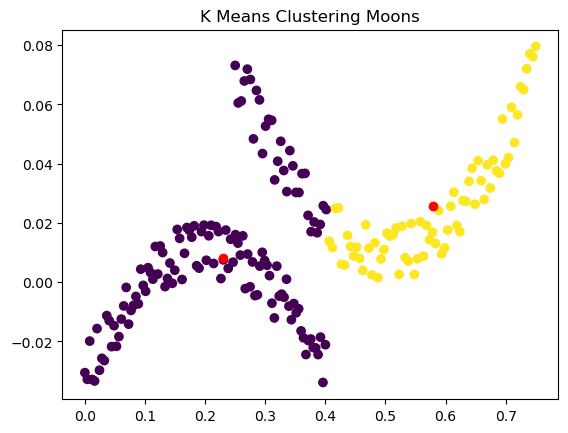

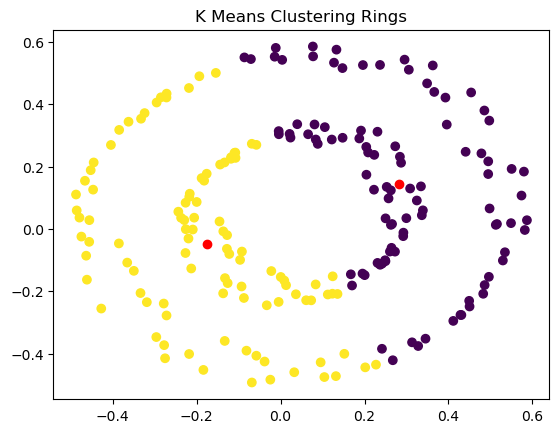

In [153]:
show_k_means_clustering(moons, "K Means Clustering Moons")
show_k_means_clustering(rings, "K Means Clustering Rings")

In [184]:
from unionfind import unionfind

class DBScan:
    
    def __init__(self, t, e):
        # t = threshold: wie viele punkte muessen im umkreis mit radius e mindestens sein
        # damit der punkt ein center point ist
        self.t = t
        # e = Radius des Umkreis
        self.e = e
        
        self.fitted = False
        
    def print_group_info(self):
        groups = self.union_find.groups()
        print(f"number of groups: {len(groups)}")
        
        for group in groups:
            print(group)
            
            representative = group[0]
            print(f"{len(group)}, repr: {representative}, label repr: {self.point_type[representative]}")
        
    
    # X = die Punkte (als Zeilen) im n-dimensionalen Raum
    def fit(self, X):
        
        n = len(X)
        
        self.fitted = True
        self.X = X
        
        # 1 = center point, 2 = border point, 3 = noise point
        self.point_type = np.zeros(n)
        
        # -1 = unassigned (noise point), 0...n = regular clusters / components
        # wir koennen nicht bei 0 anfangen, da ein cluster mit center points im unionfind auch 0 heissen kann
        self.labels = -1 * np.ones(n)
        
        border_or_noise_ix = []
        
        # finde zuerst alle center points, erst danach koennen die corner points berechnet werden
        for i in range(n):
            
            point = X[i]
            
            distances_to_point = np.linalg.norm(X - point, axis=1)
            n_points_within_radius = np.sum(distances_to_point <= self.e)
            # der naehste punkt ist immer man selbst
            n_points_within_radius -= 1
            
            if n_points_within_radius >= self.t:
                self.point_type[i] = 1
            else:
                border_or_noise_ix.append(i)
                
        for i in border_or_noise_ix:
            
            point = X[i]
            distances_to_point = np.linalg.norm(X - point, axis=1)
            points_near_ix = np.where(distances_to_point <= self.e)
            
            # es gibt mindestens einen punkt im radius von e, der ein center point ist
            if np.any(self.point_type[points_near_ix] == 1):
                self.point_type[i] = 2
            else:
                self.point_type[i] = 3
                
        # alle center points, die im radius e sind, werden miteinander verbunden (also mit union find)
        self.union_find = unionfind(n)
        
        center_points_ix = np.where(self.point_type == 1)[0]
        #print(f"Number of center points: {len(center_points_ix)}")
        
        for i in center_points_ix:
            
            point = X[i]
            distances_to_point = np.linalg.norm(X - point, axis=1)
            
            #print(f"Number of points near: {np.sum(distances_to_point <= self.e)}")
            points_near_mask = distances_to_point <= self.e
            center_points_mask = self.point_type == 1
            
            center_points_near_mask = points_near_mask & center_points_mask
            
            center_points_near_ix = np.where(center_points_near_mask == True)[0]

            #print(f"Number of center points near: {len(center_points_near_ix)}")
    
            for point_near_ix in center_points_near_ix:
                
                assert(self.point_type[i] == 1 and self.point_type[point_near_ix] == 1)
                self.union_find.unite(i, point_near_ix)
                
        
        #print("How many points: ", n)
        #print("How many groups: ", len(union_find.groups()))
        
        # weise alle border points dem naechstgelegenen cluster zu
        border_points_ix = np.where(self.point_type == 2)[0]
        
        #print(f"How many border points missing: {len(border_points_ix)}")
        
        border_point_assignment = dict()
        
        for i in border_points_ix:
            point = X[i]
            
            distances_to_point = np.linalg.norm(X - point, axis = 1)
            
            closest_cluster = -1
            min_distance = np.inf
            
            for group in self.union_find.groups():
                
                representative = group[0]
                
                # man muss cluster ausschliessen, die von border oder noise points kommen
                if self.point_type[representative] != 1:
                    continue
                
                group = np.array(group)
                distance_to_group = np.min(distances_to_point[group])
                
                if distance_to_group < min_distance:
                    min_distance = distance_to_group
                    closest_cluster = self.union_find.find(group[0])
            
            border_point_assignment[i] = closest_cluster
            # man kann erst nacher zum cluster zuweisen
            # wenn man es waehrenddessen macht, kann es sein, dass ein border point zum representaten wird
            # und man dann ein cluster ablehnt, weil es border points enthält
            
        # weisen den center points die label zu
        for i in center_points_ix:
            representative = self.union_find.find(i)
            
            self.labels[i] = representative
            
        for i in border_points_ix:
            self.labels[i] = border_point_assignment[i]

        
    def show_point_types(self, title):
        
        if not self.fitted:
            raise Exception("The model has to be fitted before it can be visualized")
            
        if self.X.shape[1] != 2:
            raise Exception("Can't visualize points in higher than 2 dimensions. Apply dimensionality reduction first")
        
        cdict = {0: "grey", 1: "green", 2: "yellow", 3: "red"}
        ldict = {0: "unassigned", 1: "center", 2: "border", 3: "noise"}
        
        plt.title(title)
        
        # man muss scatter fuer jede gruppe aufrufen
        for g in np.unique(self.point_type):
            ix = np.where(self.point_type == g)
            plt.scatter(self.X[ix, 0], self.X[ix, 1], c = cdict[g], label = ldict[g])
        
        plt.legend()
        plt.show()
    
    def show_clusters(self, title):
        
        if not self.fitted:
            raise Exception("The model has to be fitted before it can be visualized")
            
        if self.X.shape[1] != 2:
            raise Exception("Can't visualize points in higher than 2 dimensions. Apply dimensionality reduction first")
            
        plt.title(title)
        
        unassigned = self.labels == -1
        assigned = self.labels != -1
        
        plt.scatter(self.X[unassigned, 0], self.X[unassigned, 1], c="grey", label="unassigned")
        plt.scatter(self.X[assigned, 0], self.X[assigned, 1], c=self.labels[assigned])
        
        plt.legend()
        plt.show()

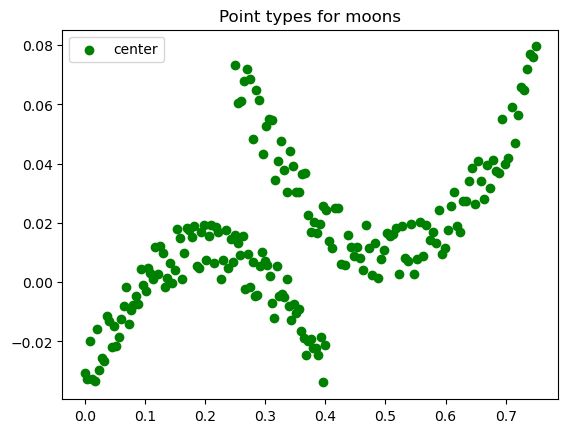

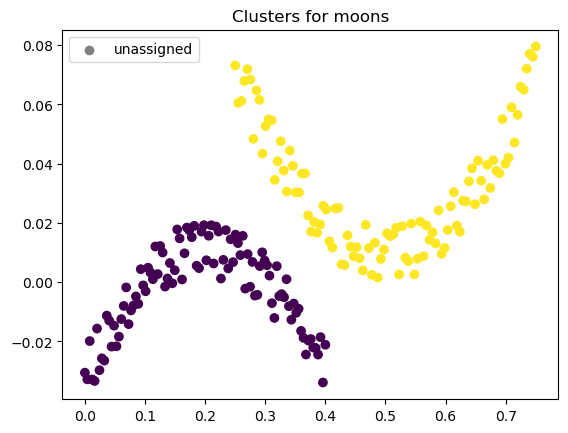

In [193]:
db_scan = DBScan(e = 0.02, t = 3)
db_scan.fit(moons)
db_scan.show_point_types("Point types for moons")
db_scan.show_clusters("Clusters for moons")

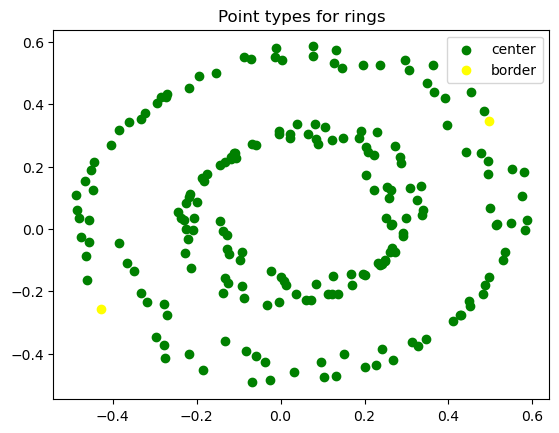

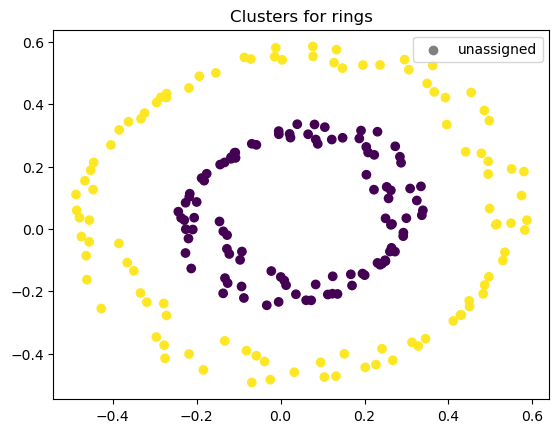

In [197]:
db_scan = DBScan(e = 0.1, t = 2)
db_scan.fit(rings)
db_scan.show_point_types("Point types for rings")
db_scan.show_clusters("Clusters for rings")